In [21]:
import os
print(os.getcwd())
import joblib
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.nn import Softmax
from torch.utils.data import DataLoader

from notebooks.load_ckpt import define_model

/home/hyeryungson/mucoco


In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### Load text data & perspective output

In [38]:
# train
sample0=pd.read_json("/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/toxicity_eq0_subsample_10000.jsonl",lines=True)
sample1=pd.read_json("/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/toxicity_gte0.5_10000.jsonl",lines=True)

api0=pd.read_csv('/home/hyeryungson/mucoco/notebooks/results/perspective_result_0_v3.csv',names=['index', 'api_proba'])
api1=pd.read_csv('/home/hyeryungson/mucoco/notebooks/results/perspective_result_1_v3.csv',names=['index', 'api_proba'])

sample0=sample0.merge(api0,on='index',how='left')
sample1=sample1.merge(api1,on='index',how='left')

sample0['label']=0
sample1['label']=1

In [39]:
len(sample0), len(sample1)

(10000, 10000)

In [3]:
# test
sample0=pd.read_json("/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/test_0.jsonl",lines=True)
sample1=pd.read_json("/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/test_1.jsonl",lines=True)

sample0['label']=0
sample1['label']=1

print(len(sample0), len(sample1))

In [19]:
# train
sample0=pd.read_json("/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/train_0.jsonl",lines=True)
sample1=pd.read_json("/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/train_1.jsonl",lines=True)

sample0['label']=0
sample1['label']=1

print(len(sample0), len(sample1))

155782 155782


### Inference with model

In [4]:
BATCH_SIZE=64
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# load trained model
ckpt_path='/home/hyeryungson/mucoco/models_bak_contd/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
model, config, tokenizer = define_model(ckpt_path)

None
None
look above for padding
Adding special tokens


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

['<s>', '<pad>', '</s>', '<unk>', 'madeupword0000', 'madeupword0001', 'madeupword0002', '<mask>']
computing vecmap
torch.Size([1280, 768]) torch.Size([768, 1280])


In [20]:
true0_enc =tokenizer(sample0['text'].tolist(), padding=True, truncation=True)
true1_enc =tokenizer(sample1['text'].tolist(), padding=True, truncation=True)

label0_data = Dataset(true0_enc, [0]*len(sample0['text']))
label1_data = Dataset(true1_enc, [0]*len(sample1['text']))

label0_dataloader = DataLoader(label0_data, batch_size=BATCH_SIZE, shuffle=False)
label1_dataloader = DataLoader(label1_data, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
logits0=[]
proba0=[]
softmax=Softmax(dim=-1)
with torch.no_grad():
    for batch in tqdm(label0_dataloader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits0.append(outputs)
        proba0.extend(softmax(outputs['logits'])[:,1].cpu().numpy())

  8%|▊         | 186/2435 [01:03<12:52,  2.91it/s]

In [13]:
logits1=[]
proba1=[]
softmax=Softmax(dim=-1)
with torch.no_grad():
    for batch in tqdm(label1_dataloader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits1.append(outputs)
        proba1.extend(softmax(outputs['logits'])[:,1].cpu().numpy())

In [58]:

joblib.dump(proba0, './logits0.pkl')
joblib.dump(proba1, './logits1.pkl')

['./logits1.pkl']

In [8]:
# proba0_=joblib.load('./logits0.pkl')
# proba1_=joblib.load('./logits1.pkl')

In [14]:
sample0['mod_proba']=proba0
sample1['mod_proba']=proba1

In [15]:
samples=pd.concat([sample0,sample1],axis=0)

In [13]:
samples.to_csv('samples.csv',index=False)

In [18]:
samples.to_csv('notebooks/results/test_data.csv',index=False)

### Plot & Analyze Model Outputs

In [5]:
samples=pd.read_csv('samples.csv')

In [7]:
sample0=samples.loc[samples['label']==0].copy()
sample1=samples.loc[samples['label']==1].copy()

/tmp/ipykernel_176736/35226972.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample0['mod_proba'], label='label0')
/tmp/ipykernel_176736/35226972.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample1['mod_proba'], label='label1')


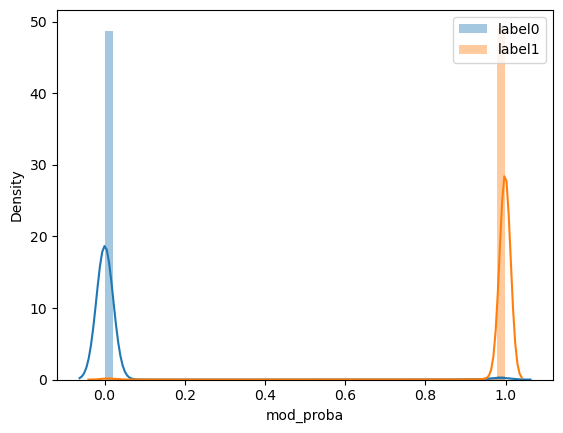

In [8]:
sns.distplot(sample0['mod_proba'], label='label0')
sns.distplot(sample1['mod_proba'], label='label1')
plt.legend(loc='upper right')

/tmp/ipykernel_231574/2734483951.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample0['mod_proba'], label='label0')
/tmp/ipykernel_231574/2734483951.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample1['mod_proba'], label='label1')


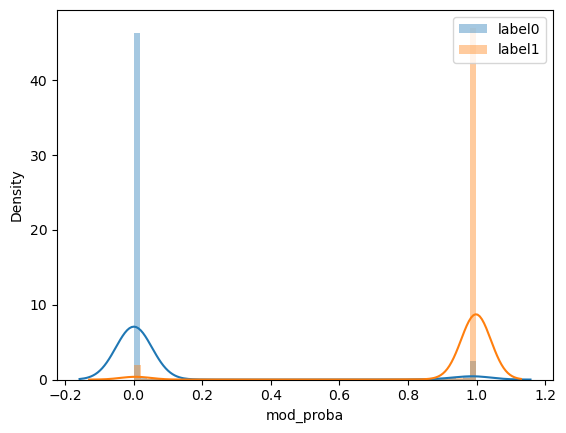

In [16]:
sns.distplot(sample0['mod_proba'], label='label0')
sns.distplot(sample1['mod_proba'], label='label1')
plt.legend(loc='upper right')

In [9]:
# accuracy
samples['mod_cpred']=samples['mod_proba'].apply(lambda x: 1 if x > 0.5 else 0)
accuracy_score(samples['label'], samples['mod_cpred'])

0.9866

In [17]:
samples['mod_cpred']=samples['mod_proba'].apply(lambda x: 1 if x > 0.5 else 0)
accuracy_score(samples['label'], samples['mod_cpred'])

0.947

In [85]:
sample0['mod_proba'].quantile(np.arange(0, 1.1, 0.1))

0.0    0.000154
0.1    0.000156
0.2    0.000157
0.3    0.000159
0.4    0.000162
0.5    0.000167
0.6    0.000177
0.7    0.000206
0.8    0.000319
0.9    0.000945
1.0    0.999706
Name: mod_proba, dtype: float64

In [86]:
sample1['mod_proba'].quantile(np.arange(0, 1.1, 0.1))

0.0    0.000156
0.1    0.996060
0.2    0.998483
0.3    0.999058
0.4    0.999342
0.5    0.999540
0.6    0.999647
0.7    0.999703
0.8    0.999731
0.9    0.999750
1.0    0.999774
Name: mod_proba, dtype: float64